## install bpy
- [參考網站](https://www.zhihu.com/question/386776864)
- steps
    1. `conda create -n ***`
    2. 至 https://pypi.org/project/bpy/#files 查看 python 版本 (cp***)
    3. 安裝對應 python 版本 `conda install python=***`
    4. `pip install bpy`
- (記得切換 kernel -> `conda activate bpy`)
## steps and references
- preprocessing
    - [convert curve to mesh](https://blender.stackexchange.com/questions/265215/how-can-i-convert-a-curve-to-a-mesh-object)
    - [get vertices from mesh](https://blender.stackexchange.com/questions/1311/how-can-i-get-vertex-positions-from-a-mesh)
    - [get original colors](https://blenderartists.org/t/svg-import-remove-redundant-materials/693325/4)
- create mesh
    - [triangulate polygon in shapely](https://stackoverflow.com/questions/65019170/how-do-you-triangulate-a-polygon-in-shapely)
- simplification
    - ~~[tripy](https://github.com/linuxlewis/tripy)~~
    - ~~[optimization](https://github.com/meshpro/optimesh)~~
    - [triangulate](https://github.com/lionfish0/earclip)
## other packages
- `pip install scipy`
- `pip install shapely`
- `pip install geopandas`
- `pip install geovoronoi`
- `pip install tripy`
- `pip install optimesh`

In [53]:
import numpy as np
import bpy
import matplotlib.pyplot as plt
import shapely.wkt
import geopandas as gpd
import tripy
import optimesh
import warnings
import torch
import colorsys

from shapely.geometry import Polygon
from shapely.ops import triangulate
from matplotlib.lines import Line2D
from geovoronoi import voronoi_regions_from_coords
from quad_mesh_simplify import simplify_mesh
from collections import OrderedDict
# from utils.earclip import triangulate
from torch_geometric.data import Data
from scipy.spatial import Delaunay

In [70]:
# import file
file_path = "./datasets/svg/011-library.svg"
# file_path = "./datasets/svg/027-diamond.svg"
# file_path = "./datasets/svg/019-watermelon.svg"
file_path = "./datasets/svg/cherry-230123-1.svg"
# file_path = "./datasets/svg/032-firewood.svg"
# file_path = "./datasets/svg/050-shopping cart.svg"
# file_path = "./datasets/svg/037-time.svg"

# clean the scene
bpy.ops.object.select_all()
bpy.ops.object.delete()

bpy.ops.import_curve.svg(filepath=file_path)

{'FINISHED'}

In [71]:
# convert curve to mesh
idx = 0
for ob in bpy.data.objects:
    if ob.type == "CURVE":
        mesh = bpy.data.meshes.new_from_object(ob)
        new_obj = bpy.data.objects.new("mesh_obj" + str(idx), mesh)
        new_obj.matrix_world = ob.matrix_world
        bpy.context.collection.objects.link(new_obj)
        idx += 1

In [72]:
# get all curve meshes
colors = {}
nodes = {}
idx = 0
hsv = {}
for ob in bpy.data.objects:
    if ob.type == "MESH" and "mesh_obj" in ob.name:
        try:
            # get mesh
            rgb = ob.material_slots[0].material.diffuse_color
            colors[idx] = np.array([rgb[0], rgb[1], rgb[2]])
            hsv[idx] = np.array(colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2]))
            
            # get vertices
            v = ob.data.vertices[0]
            coords = [(ob.matrix_world @ v.co) for v in ob.data.vertices]  # (x, y, z)
            nodes[idx] = []
            for x, y, z in coords:
                nodes[idx].append([x, y]) 
            nodes[idx] = np.array(nodes[idx])
            
            idx += 1
        except:
            continue

In [73]:
def to_triangles(poly_points):
    polygon = Polygon(poly_points).buffer(-0.0000001)

    # poly_points = []
    # warnings.filterwarnings("ignore")
    
    # gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.0000001).exterior]}).explode().reset_index()
    # for geom in gdf_poly_exterior.geometry:
    #     poly_points += np.array(geom.coords).tolist()

    # try:
    #     polygon.interiors[0]
    # except:
    #     poly_points = poly_points
    # else:
    #     gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
    #     for geom in gdf_poly_interior.geometry:
    #       poly_points += np.array(geom.coords).tolist()

    # poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles
    
    return tri_geom

In [112]:
# triangulate
polys = {}
idx = 0
for i, node in nodes.items():
    polys[i] = []
    if len(node) < 4: continue
    
    poly = Polygon(node).buffer(0.001)
    tri = triangulate(poly)
    for po in tri:
        xx, yy = po.exterior.coords.xy
        temp = []
        for x, y in zip(xx, yy):
            temp.append([x, y])
        polys[i].append(temp[:3])
    polys[i] = np.array(polys[i])
    
    # try:
    #     res = to_triangles(node)
    # except:
    #     continue
    # for poly in res:
    #     xx, yy = poly.exterior.coords.xy
    #     temp = []
    #     for x, y in zip(xx, yy):
    #         temp.append([x, y])
    #     polys[i].append(temp[:3])
    # polys[i] = np.array(polys[idx])
    # idx += 1

    # try:
    #     tri = Delaunay(node)
    # except:
    #     continue
    # polys[idx] = node[tri.simplices]
    # idx += 1

In [113]:
# fig = plt.figure("plot")
# ax = fig.add_subplot(1, 1, 1)
# plt.axis("off")

all_points = []
all_edges = []
all_rgb = []
all_hsv = []
all_cluster = []
add_num = 0
idx = 0

for i, poly in polys.items():
    if len(poly) == 0: continue
    
    p_i = 0
    pos2idx = {}
    points = []
    cells = []
    for n1, n2, n3 in poly:
        if tuple(n1) not in pos2idx:
            pos2idx[tuple(n1)] = p_i
            points.append(n1)
            all_rgb += [colors[i].tolist()]
            all_hsv += [hsv[i].tolist()]
            p_i += 1
        if tuple(n2) not in pos2idx:
            pos2idx[tuple(n2)] = p_i
            points.append(n2)
            all_rgb += [colors[i].tolist()]
            all_hsv += [hsv[i].tolist()]
            p_i += 1
        if tuple(n3) not in pos2idx:
            pos2idx[tuple(n3)] = p_i
            points.append(n3)
            all_rgb += [colors[i].tolist()]
            all_hsv += [hsv[i].tolist()]
            p_i += 1       
        cells.append([pos2idx[tuple(n1)], pos2idx[tuple(n2)], pos2idx[tuple(n3)]])
        
    points = np.array(points)
    cells = np.array(cells) 
    points, cells = optimesh.optimize_points_cells(
        points, cells, "cpt-quasi-newton", 1.0e-5, 100
    )
    
    if idx == 0:
        all_points = points
    else:
        all_points = np.concatenate((all_points, points), axis=0)
    for a, b, c in cells:
        all_edges.append([a+add_num, b+add_num])
        all_edges.append([b+add_num, c+add_num])
        all_edges.append([c+add_num, a+add_num])
    add_num += len(points)
    
    all_cluster += [idx for _ in range(len(points))]
    idx += 1
    
all_points = np.array(all_points)
all_edges = np.array(all_edges)
all_rgb = np.array(all_rgb)
all_hsv = np.array(all_hsv)
all_cluster = np.array(all_cluster)

<string>:144: UserWarning: After 101 edge flip steps, there are 7 remaining non-Delaunay facets. The signed circumcenter distances are [-1.9949319973733282e-17, -1.3227266504323154e-16, -5.702903427273753e-17, -2.6454533008646308e-17, -1.3010426069826053e-17, -5.637851296924623e-18, -2.3310346708438345e-17]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
<string>:144: UserWarning: After 101 edge flip steps, there are 2 remaining non-Delaunay facets. The signed circumcenter distances are [-4.7488055154865094e-17, -5.702903427273753e-17]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
<string>:144: UserWarning: After 10 edge flip steps, there are 2 remaining non-Delaunay facets. The signed circumcenter distances are [-4.445228907190568e-18, -1.938553484404082e-16]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
<string>:144: UserWarning: After 101 edge flip ste

In [114]:
print(f"number of all points: {len(all_points)}; type: {type(all_points)}; shape: {all_points.shape}")
print(f"number of all edges: {len(all_edges)}; type: {type(all_edges)}; shape: {all_edges.shape}")
print(f"rgb: {all_rgb.shape}; hsv: {all_hsv.shape}; cluster: {all_cluster.shape}")

number of all points: 980; type: <class 'numpy.ndarray'>; shape: (980, 2)
number of all edges: 3702; type: <class 'numpy.ndarray'>; shape: (3702, 2)
rgb: (980, 3); hsv: (980, 3); cluster: (980,)


In [115]:
# create pyg data
# nodes
x = torch.Tensor(all_points)
y_rgb = torch.Tensor(all_rgb)
y_hsv = torch.Tensor(all_hsv)
y_cluster = torch.Tensor(all_cluster)

# edges
m = all_edges.shape[0]
edges = np.zeros([2*m, 2]).astype(np.int64)
edge_attr = np.zeros([2*m, 4]).astype(np.float32)
for e, (s,t) in enumerate(all_edges):
    edges[e, 0] = s
    edges[e, 1] = t
    edges[m+e, 0] = t
    edges[m+e, 1] = s
    
    edge_attr[e, :2] = all_points[s]
    edge_attr[e, 2:] = all_points[t]
    edge_attr[m+e, :2] = all_points[t]
    edge_attr[m+e, 2:] = all_points[s]
edges = torch.Tensor(np.transpose(edges)).type(torch.long)
edge_attr = torch.Tensor(edge_attr)

data = Data(x=x, edge_index=edges, rgb=y_rgb, hsv=y_hsv, edge_attr=edge_attr, cluster=y_cluster)
print(data)

Data(x=[980, 2], edge_index=[2, 7404], edge_attr=[7404, 4], rgb=[980, 3], hsv=[980, 3], cluster=[980])


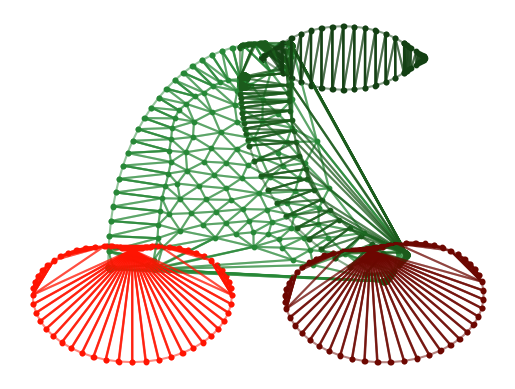

In [116]:
fig = plt.figure("plot")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")
 
for i, p in enumerate(all_points):
    plt.scatter(p[0], p[1], s=10, color=all_rgb[i])
for n1, n2 in all_edges:
    x1, y1 = all_points[n1]
    x2, y2 = all_points[n2]
    l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=all_rgb[n1])
    ax.add_line(l)

plt.show()

---
---

In [157]:
# # create mesh points and cells numpy array
# pos_to_idx = {}
# idx_to_pos = {}
# mesh_faces = {}
# mesh_points = {}
# i = 0

# for poly_list in polys.values():
#     cnt = 0
#     pos_to_idx[i] = {}
#     idx_to_pos[i] = {}
#     mesh_faces[i] = []
    
#     for pos in poly_list:
#         for p in pos:
#             if tuple(p) not in pos_to_idx[i]:
#                 pos_to_idx[i][tuple(p)] = cnt
#                 cnt += 1
#         mesh_faces[i].append([pos_to_idx[i][tuple(pos[0])], pos_to_idx[i][tuple(pos[1])], pos_to_idx[i][tuple(pos[2])]])
    
#     idx_to_pos[i] = {v: k for k, v in pos_to_idx[i].items()}
#     mesh_faces[i] = np.array(mesh_faces[i])
#     i += 1
    
# for i, d in idx_to_pos.items():
#     mesh_points[i] = []
#     for v in d.values():
#         mesh_points[i].append(list(v))
#     mesh_points[i] = np.array(mesh_points[i])
    
# # optimize
# for i, (ori_points, ori_cells) in enumerate(zip(mesh_points.values(), mesh_faces.values())):
#     if (len(ori_points) == 0): continue
    
#     points, cells = optimesh.optimize_points_cells(
#         ori_points, ori_cells, "cpt-quasi-newton", 1.0e-5, 100
#     )

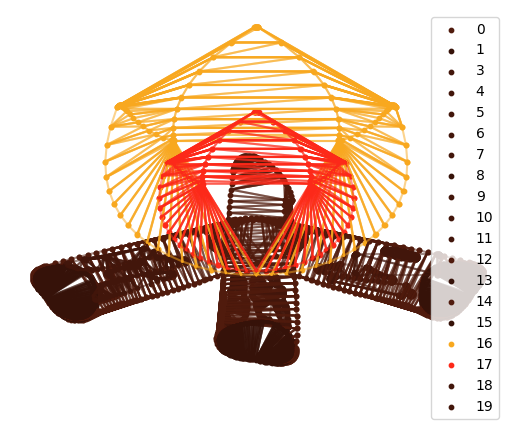

In [156]:
# # mesh simplification
# fig = plt.figure("plot")
# ax = fig.add_subplot(1, 1, 1)
# plt.axis("off")

# new_points = []
# new_colors = []
# new_edges = []
# idx = 0
# out_points = {}

# for i, (ori_points, ori_cells) in enumerate(zip(mesh_points.values(), mesh_faces.values())):
#     if (len(ori_points) == 0): continue
    
#     # z = np.zeros([len(ori_points), 1])
#     # ori_points = np.concatenate((ori_points, z), axis=1)
#     # ori_cells = ori_cells.astype(np.uint32)
    
#     # warnings.filterwarnings("ignore")
      
#     # points, cells = simplify_mesh(ori_points, ori_cells, 10, max_err=0.2)
#     # points = points[:,:2]
    
#     points, cells = optimesh.optimize_points_cells(
#         ori_points, ori_cells, "cpt-quasi-newton", 1.0e-5, 100
#     )
    
#     # points, cells = ori_points, ori_cells
    
#     # build points and colors
#     out_points[idx] = points
#     c_temp = [colors[i]] * len(points)
#     if idx == 0:
#         new_points = points
#         new_colors = c_temp
#     else:
#         new_points = np.concatenate((new_points, points), axis=0)
#         new_colors = np.concatenate((new_colors, c_temp), axis=0)
    
#     # add edges
#     for a, b, c in cells:
#         new_edges.append([a+idx, b+idx])
#         new_edges.append([b+idx, c+idx])
#         new_edges.append([c+idx, a+idx])
#     idx += len(points)
    
#     # print(f"cluster {i}:\n\
#     #       number of original/new points = {len(ori_points)} / {len(points)}\n\
#     #       number of original/new faces = {len(ori_cells)} / {len(cells)}")
    
#     plt.scatter(points[:,0], points[:,1], color=colors[i], s=10, label=i)
#     for a, b, c in cells:
#         x1, y1 = points[a]
#         x2, y2 = points[b]
#         x3, y3 = points[c]
#         l = Line2D([x1,x2], [y1,y2], color=colors[i], alpha=0.5)
#         ax.add_line(l)
#         l = Line2D([x1,x3], [y1,y3], color=colors[i], alpha=0.5)
#         ax.add_line(l)
#         l = Line2D([x3,x2], [y3,y2], color=colors[i], alpha=0.5)
#         ax.add_line(l)

# new_points = np.array(new_points)        
# new_colors = np.array(new_colors)
# new_edges = np.array(new_edges)

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
# plt.show()